In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
print(os.getcwd())

def check_color_rgb(img):
    return img.ndim == 3 and img.shape[2] == 3

def show_compare_images(left_img, left_title, right_img, right_title):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        if check_color_rgb(left_img):
            ax1.imshow(left_img)
        else:
            ax1.imshow(left_img, cmap='gray')
        ax1.set_title(left_title, fontsize=50)
        if check_color_rgb(right_img):
            ax2.imshow(right_img)
        else:
            ax2.imshow(right_img, cmap='gray')
        ax2.set_title(right_title, fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

/Users/takashi/Documents/SelfDrivingCar/CarND-Advanced-Lane-Lines


### camera calibration

In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pickle
%matplotlib inline

nx = 9
ny = 6

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

def load_camera_cal_images():
    images = []
    for name in glob.glob('camera_cal/*.jpg'):
        img = cv2.imread(name)
        images.append(img)
    return images

def get_points(images, objpoints, imgpoints):
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

def save_calibration_info(mtx, dist):
    with open('mtx.pkl', 'wb') as f:
        pickle.dump(mtx, f)
    with open('dist.pkl', 'wb') as f:
        pickle.dump(dist, f)
        
def check_mean_error(objpoints, imgpoints, rvecs, tvecs, mtx, dist):
    mean_error = 0
    for i in range(0, len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error += error
    print("mean_error: ", mean_error/len(objpoints)) 

def save_undistored_images(images, mtx, dist):
    for i, img in enumerate(images):
        undistorted = cv2.undistort(img, mtx, dist, None, mtx)
        show_compare_images(img, 'Original Image', undistorted, 'Undistorted Image')
        plt.savefig("output_images/undistort_output_" + str(i) + ".png")
        
def camera_calibrate():
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    images = load_camera_cal_images()

    get_points(images, objpoints, imgpoints)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, images[0].shape[1::-1], None, None)
    save_calibration_info(mtx, dist)

    check_mean_error(objpoints, imgpoints, rvecs, tvecs, mtx, dist)
    save_undistored_images(images, mtx, dist)
    
camera_calibrate()

### distortion-corrected image

/Users/takashi/Documents/SelfDrivingCar/CarND-Advanced-Lane-Lines


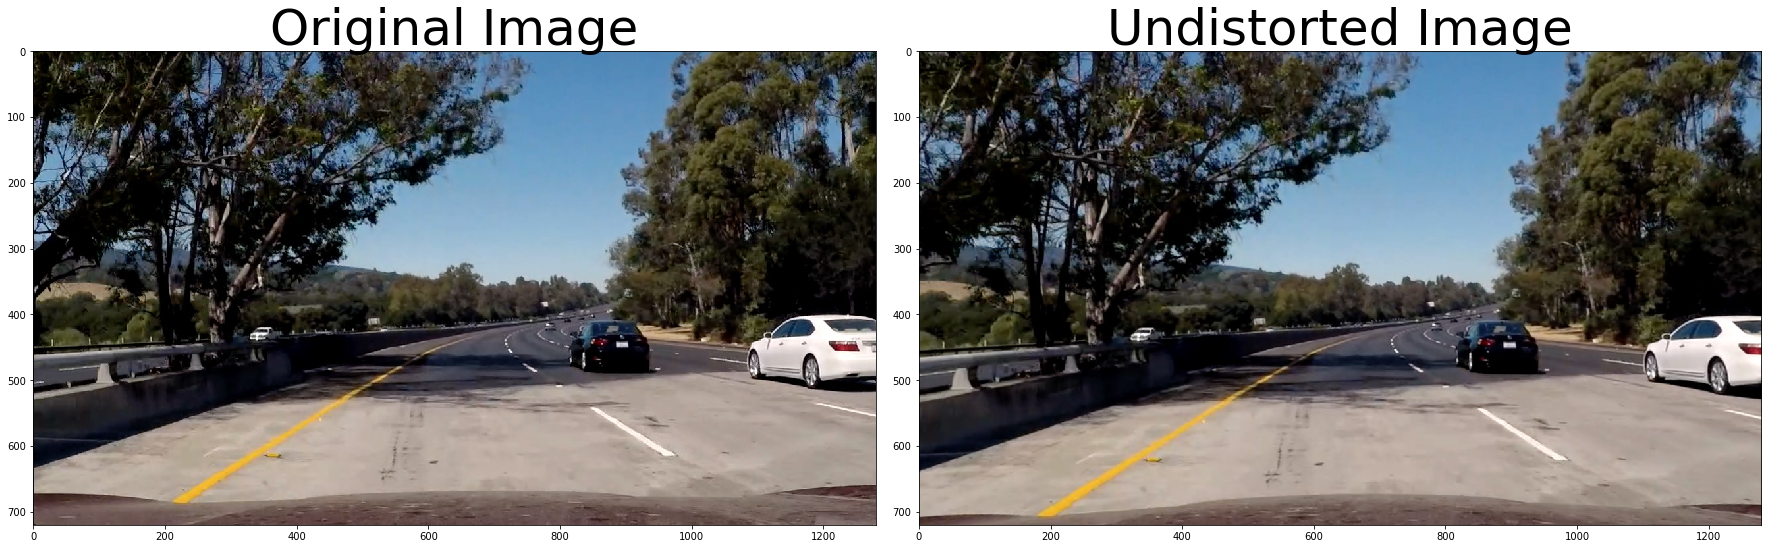

In [24]:
import pickle  
import cv2
import matplotlib.image as mpimg

import os
cwd = os.getcwd()
print(cwd)
img_test5 = mpimg.imread("./test_images/test5.jpg")

with open('mtx.pkl', 'rb') as f:
    mtx = pickle.load(f)
with open('dist.pkl', 'rb') as f:
    dist = pickle.load(f)
        
img_test5_undistorted = cv2.undistort(img_test5, mtx, dist, None, mtx)
show_compare_images(img_test5, 'Original Image', img_test5_undistorted, 'Undistorted Image')
plt.savefig("output_images/undistort_output_test5.png")

### sobel operator

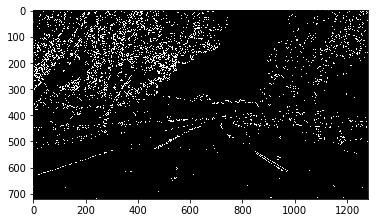

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    s_binary = np.zeros_like(gray)
    s_binary[(gradmag > thresh[0]) & (gradmag <= thresh[1])] = 1
    return s_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def combine_threshold(image):
    ksize = 3
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined


plt.imshow(combine_threshold(img_test5), cmap='gray')
plt.show()


### color transform

2


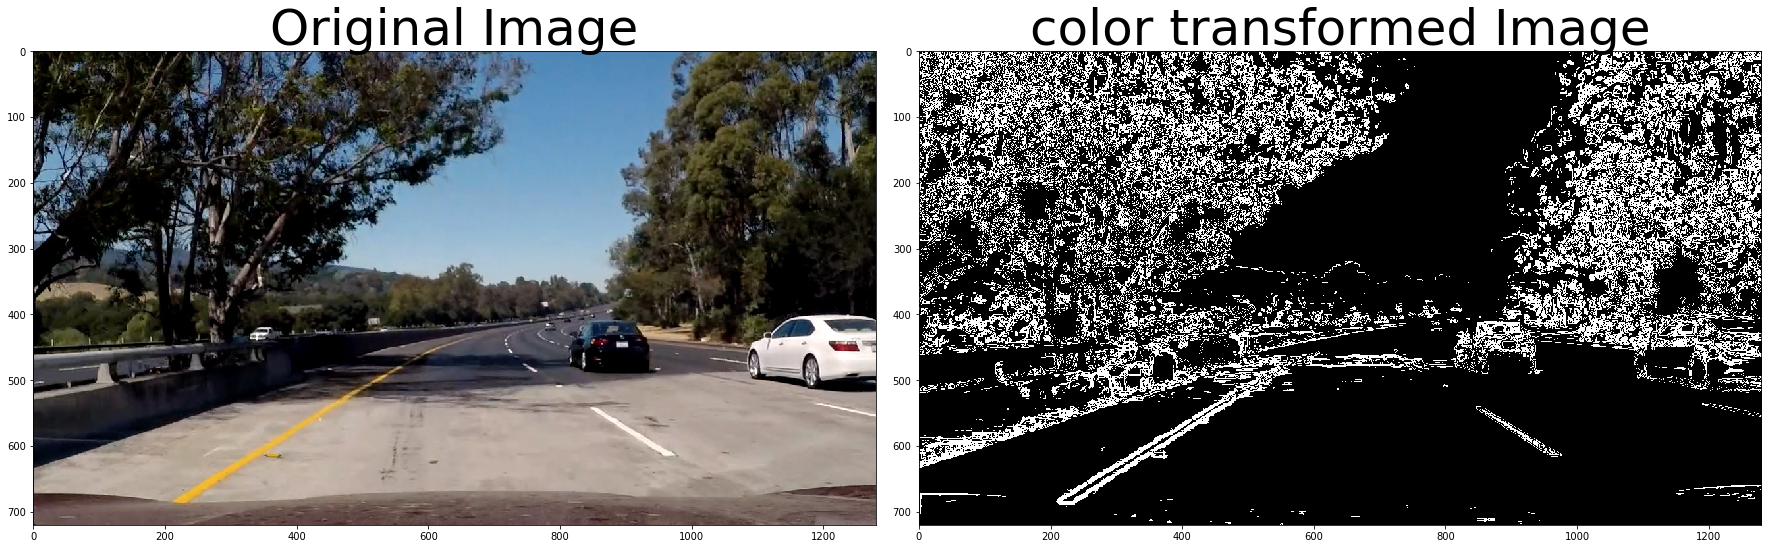

In [32]:
import cv2


# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(90, 255), sobel_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) 
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1) 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # Threshold x gradient
    sobel_binary = np.zeros_like(gradmag)
    sobel_binary[(gradmag >= sobel_thresh[0]) & (gradmag <= sobel_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    combine = np.zeros_like(s_channel)
    combine[(sobel_binary == 1) | (s_channel == 1)] = 1
    
    return combine
    
img_test5_color_transformed = pipeline(img_test5)
show_compare_images(img_test5, 'Original Image', img_test5_color_transformed, 'color transformed Image')

### perspective transform and provide an example of a transformed image

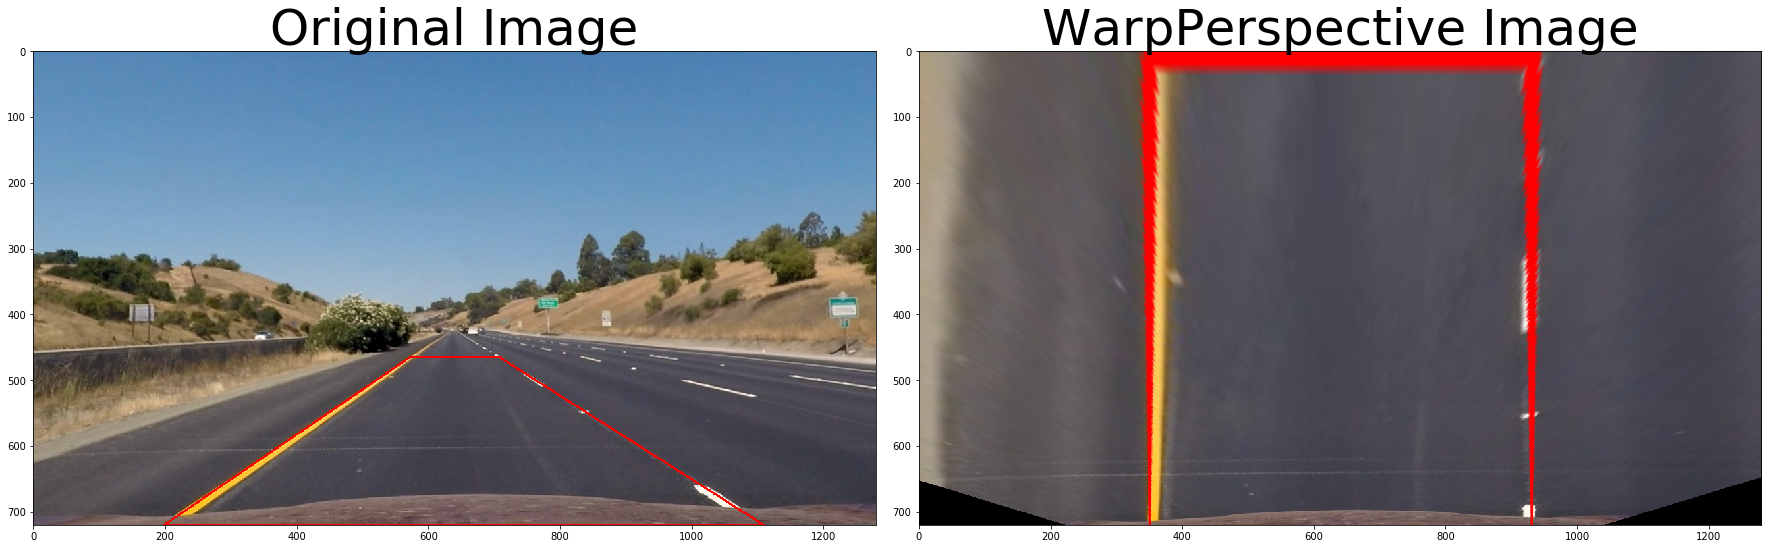

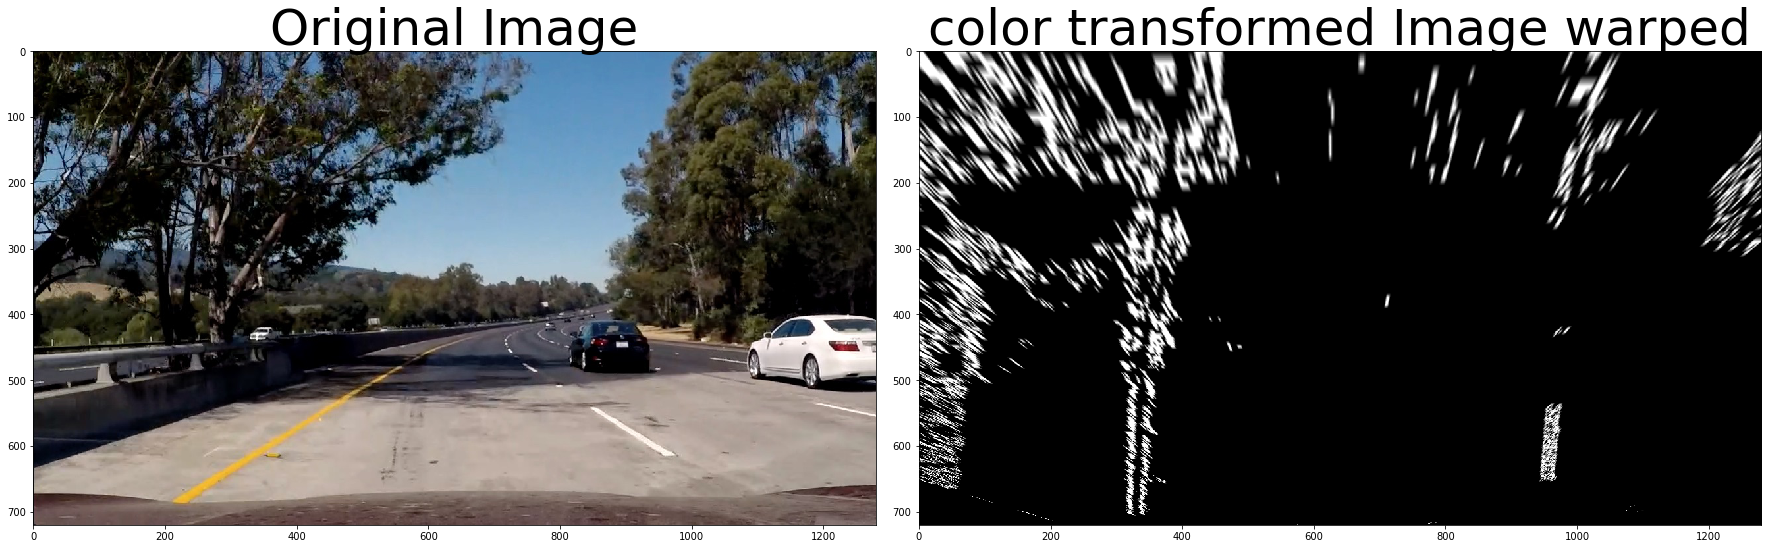

In [27]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import numpy as np

with open('mtx.pkl', 'rb') as f:
    mtx = pickle.load(f)
with open('dist.pkl', 'rb') as f:
    dist = pickle.load(f)

def PerspectiveTransformMatrix():
    src = np.float32([[198,720], [1110,720],[707,464],[573,464]])
    dst =np.float32([[350, 720], [930,720],[930,0],[350,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    
    def save_sample_image():
        straight_image = mpimg.imread("test_images/straight_lines1.jpg")
        straight_image = cv2.undistort(straight_image, mtx, dist, None, mtx)
        for i, p in enumerate(src):
            cv2.line(straight_image, tuple(p), tuple(src[(i+1) % 4]), (255,0,0), 2)
        warped = cv2.warpPerspective(straight_image, M, straight_image.shape[1::-1])
        
        show_compare_images(straight_image, 'Original Image', warped, 'WarpPerspective Image')
        plt.savefig("output_images/WarpPerspective.png")
        
    save_sample_image()
    return M

M = PerspectiveTransformMatrix()
img_test5_color_transformed_warped = cv2.warpPerspective(img_test5_color_transformed, M, img_test5_color_transformed.shape[1::-1])
show_compare_images(img_test5, 'Original Image', img_test5_color_transformed_warped, 'color transformed Image warped')
